# Preparations

<b>Load Libraries</b>

In [1]:
# udf 
import os, sys
cwd = os.getcwd()
os.chdir('../')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.notebook.support import *
from src.mlflow.support import *

# others 
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
# materials
materials = prepare_data_to_train(path='../cache/data/cleaned.csv')

<b>MLflow</b>

In [3]:
# local server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='cache/mlflow/')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

# 1. Baseline Evaluation

In [25]:
# dtype's indexs separation
num_iters = materials['X_train'].shape[1]
num_idxes, cat_idxes = [], []
for i in range(num_iters):
    try:
        float(materials['X_train'][0, i])
        num_idxes.append(i)
    except:
        cat_idxes.append(i)

In [27]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# trasnformers
ct = ColumnTransformer([('num', SimpleImputer(strategy='mean'), num_idxes), 
                        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)])

# pipeline
pipelines = []
for name, model in base_models:
    pipeline = Pipeline([('trans', ct), 
                         (name, model)])
    pipelines.append((name, pipeline))

kfold_results = get_kfold_results(pipelines, materials['X_train'], materials['y_train'])

LR: 0.5548661113299678 (0.04369139815455173)
KNN: 0.4548394723104091 (0.03433325221650186)
SVM: 0.0 (0.0)
CART: 0.4957749959043213 (0.04017658776461393)
ET: 0.4762630518355428 (0.04303123938382178)
RF: 0.5043925188651162 (0.03944302455773444)
GB: 0.5274743896158584 (0.043488587685004416)
LGBM: 0.5382867199463449 (0.036403060684741764)
XGB: 0.5193133799161977 (0.039198658078844165)


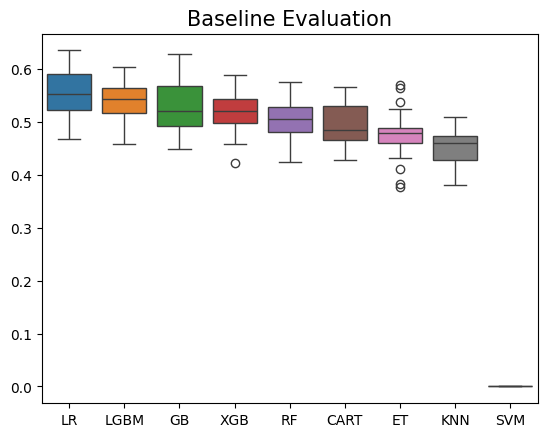

In [28]:
# plot kfold results
plot_kfold_results(kfold_results, 'Baseline Evaluation')

In [31]:
# mlflow
for name, pipeline in pipelines:
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                            beta=2)
    ##
    with mlflow.start_run():
        ### tags
        mlflow.set_tags({'pre_pro': 'si(mean)_ohe', 
                         'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': kfold_results[name].mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(artifact_path='model', 
                                 sk_model=pipeline)

In [8]:
# infer pip requirements
runs_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_ohe'"
)['run_id'].values[0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{runs_id}/model', 
    flavor='sklearn'
)
pip_requirements.extend(['mlxtend==0.23.1', 'pickle==4.0'])
pip_requirements

['cloudpickle==3.0.0',
 'imbalanced-learn==0.12.3',
 'numpy==1.26.4',
 'psutil==6.0.0',
 'scikit-learn==1.5.1',
 'scipy==1.14.0',
 'mlxtend==0.23.1',
 'pickle==4.0']

# 2. Scaling

<b>Standardization</b>

In [11]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

std = Node('std', StandardScaler())
std.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
std.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

left = [std, impute]
right = [ohe]

tree = InitBinaryTree(left, right)

In [13]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/notebook/si(mean)_std_ohe.pkl', 
                  'model': f'../cache/notebook/{str(uuid.uuid4())}.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2),
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump sfs
test_dump_model(sfs, artifacts_path['feature_selector'])
## dump pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
test_dump_model(pipeline, artifacts_path['model'])


[2024-08-15 14:34:33] Features: 1/19 -- score: 0.0
[2024-08-15 14:34:43] Features: 2/19 -- score: 0.00615018734766634
[2024-08-15 14:34:52] Features: 3/19 -- score: 0.49925779405829285
[2024-08-15 14:35:02] Features: 4/19 -- score: 0.5274875320804419
[2024-08-15 14:35:12] Features: 5/19 -- score: 0.5414428441950428
[2024-08-15 14:35:22] Features: 6/19 -- score: 0.5505037303251487
[2024-08-15 14:35:32] Features: 7/19 -- score: 0.5618708201023283
[2024-08-15 14:36:00] Features: 8/19 -- score: 0.5619902945208233
[2024-08-15 14:35:50] Features: 9/19 -- score: 0.560946138670761
[2024-08-15 14:36:18] Features: 10/19 -- score: 0.5638341704494244
[2024-08-15 14:36:07] Features: 11/19 -- score: 0.5619817645716164
[2024-08-15 14:36:16] Features: 12/19 -- score: 0.5565316852126656
[2024-08-15 14:36:25] Features: 13/19 -- score: 0.5581831426214133
[2024-08-15 14:36:32] Features: 14/19 -- score: 0.5555221346377693
[2024-08-15 14:36:39] Features: 15/19 -- score: 0.5526635112134836
[2024-08-15 14:36

In [16]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    mlflow.set_tags({'pre_pro': 'si(mean)_std_ohe', 
                     'base_model': 'LR', 
                     'feature_selection': 'true',
                     'beta_f': 2})
    ### metrics
    mlflow.log_metrics({'avg_fbeta': sfs.k_score_, 
                        'val_fbeta': val_fbeta})
    ### pipeline
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path,
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

2024/08/15 14:38:22 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


<b>Power Transformation</b>

In [11]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('pwt', PowerTransformer(method='yeo-johnson'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), PowerTransformer(method='yeo-johnson')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [12]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/notebook/si(mean)_pwt_ohe.pkl', 
                  'model': f'../cache/notebook/{str(uuid.uuid4())}.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump 
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-14 14:05:27] Features: 1/19 -- score: 0.3361781255856417
[2024-08-14 14:05:38] Features: 2/19 -- score: 0.46253800344067886
[2024-08-14 14:05:49] Features: 3/19 -- score: 0.4831835418535041
[2024-08-14 14:06:00] Features: 4/19 -- score: 0.5128423120604098
[2024-08-14 14:06:14] Features: 5/19 -- score: 0.5316098718160551
[2024-08-14 14:06:45] Features: 6/19 -- score: 0.5401812282298423
[2024-08-14 14:06:39] Features: 7/19 -- score: 0.5400414500050618
[2024-08-14 14:06:51] Features: 8/19 -- score: 0.5438148203534562
[2024-08-14 14:07:02] Features: 9/19 -- score: 0.5466159221776922
[2024-08-14 14:07:31] Features: 10/19 -- score: 0.5479701475505128
[2024-08-14 14:07:41] Features: 11/19 -- score: 0.548914569944774
[2024-08-14 14:07:51] Features: 12/19 -- score: 0.5489446327480668
[2024-08-14 14:07:44] Features: 13/19 -- score: 0.546940887968206
[2024-08-14 14:07:54] Features: 14/19 -- score: 0.5449865803773242
[2024-08-14 14:08:03] Features: 15/19 -- score: 0.5411112516763976
[202

In [13]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    mlflow.set_tags({'pre_pro': 'si(mean)_pwt_ohe', 
                     'base_model': 'LR', 
                     'feature_selection': 'true',
                     'beta_f': 2})
    ### metrics
    mlflow.log_metrics({'avg_fbeta': sfs.k_score_, 
                        'val_fbeta': val_fbeta})
    ### log
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(),
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

2024/08/14 14:12:27 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


<b>Quantile Transformation</b>

In [8]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('qtt', QuantileTransformer(output_distribution='normal'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), QuantileTransformer(output_distribution='normal')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [9]:
# warnings
simplefilter(action='ignore')

# artifacts_path
artifacts_path = {'feature_selector': '../cache/notebook/si(mean)_qtt_ohe.pkl', 
                  'model': f'../cache/notebook/{str(uuid.uuid4())}.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2

)
sfs.fit(materials['X_train'], materials['y_train'])
## dump
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-14 14:50:41] Features: 1/19 -- score: 0.23122695487820602
[2024-08-14 14:50:52] Features: 2/19 -- score: 0.4565492052428545
[2024-08-14 14:50:46] Features: 3/19 -- score: 0.49265232271954207
[2024-08-14 14:50:57] Features: 4/19 -- score: 0.5069162013907991
[2024-08-14 14:51:09] Features: 5/19 -- score: 0.5331146064709783
[2024-08-14 14:51:20] Features: 6/19 -- score: 0.54759979637967
[2024-08-14 14:51:30] Features: 7/19 -- score: 0.5469001766472168
[2024-08-14 14:51:41] Features: 8/19 -- score: 0.5427980577482816
[2024-08-14 14:51:52] Features: 9/19 -- score: 0.5445082417212952
[2024-08-14 14:52:02] Features: 10/19 -- score: 0.5441233437120379
[2024-08-14 14:52:12] Features: 11/19 -- score: 0.542990039711352
[2024-08-14 14:52:23] Features: 12/19 -- score: 0.5422281433192917
[2024-08-14 14:52:33] Features: 13/19 -- score: 0.5456042601286419
[2024-08-14 14:52:42] Features: 14/19 -- score: 0.5500419262936262
[2024-08-14 14:53:08] Features: 15/19 -- score: 0.55259763253082
[2024-

In [10]:
# mflow
## 
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    mlflow.set_tags({'pre_pro': 'si(mean)_qtt_ohe', 
                     'base_model': 'LR', 
                     'feature_selection': 'true', 
                     'beta_f': 2})
    ### metrics
    mlflow.log_metrics({'avg_fbeta': sfs.k_score_, 
                        'val_fbeta': val_fbeta})
    ###
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

2024/08/14 14:53:08 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


# 3. Factor Analysis

# 4. Resampling

In [17]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('std', StandardScaler())
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [18]:
# data
artifacts_path = {'feature_selector': '../cache/notebook/si(mean)_std_ohe.pkl'}
with open(artifacts_path['feature_selector'], 'rb') as f:
    sfs = pickle.load(f)
selected_X_train = sfs.transform(materials['X_train'])

In [19]:
# warnings
simplefilter(action='ignore')

# resamplers
resamplers = load_resammplers()

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# evaluation 
kfold_results = dict()
for name, resampler in resamplers:
    ##
    pipeline = [(name, Pipeline([('trans', transformers), (name, resampler)] + base_model))]
    cv_results = get_kfold_results(pipeline, selected_X_train, materials['y_train'])
    kfold_results.update(cv_results)
    ##
    _, pipeline = pipeline[0]
    pipeline.fit(selected_X_train, materials['y_train'])
    artifacts_path['model'] = f'../cache/notebook/{str(uuid.uuid4())}.pkl'
    test_dump_model(pipeline, artifacts_path['model'])
    ## mlflow
    val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ### tags
        mlflow.set_tags({'pre_pro': f'si(mean)_std_ohe_{name.lower()}', 
                         'base_model': 'LR', 
                         'feature_selection': 'true', 
                         'beta_f': 2})
        ### metrics
        mlflow.log_metrics({'avg_fbeta': cv_results[name].mean(), 
                            'val_fbeta': val_fbeta})
        ### model
        mlflow.pyfunc.log_model(artifact_path='model', 
                                python_model=MLflowModel(), 
                                artifacts=artifacts_path, 
                                signature=infer_signature(materials['X_train']),
                                pip_requirements=pip_requirements)

ROS: 0.7060969539293152 (0.030120432611275047)


2024/08/15 14:39:06 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


SMOTE: 0.704627434573926 (0.024500491895288006)


2024/08/15 14:39:08 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


SMOTEENN: 0.7406310323292561 (0.014409149366938278)


2024/08/15 14:39:10 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


SMOTETomek: 0.7219194764517856 (0.021845425296589508)


2024/08/15 14:39:12 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


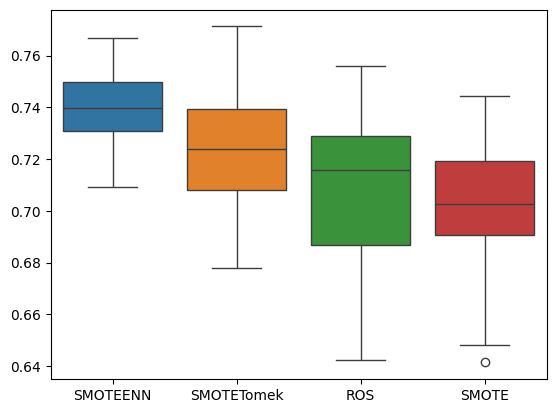

In [20]:
# plot
plot_kfold_results(kfold_results)

# 5. Finalize Model

In [4]:
# search runs
## notes: if using nodes, the function for the node should be present in memory 
run_id = mlflow.search_runs(
    filter_string="tag.pre_pro = 'si(mean)_std_ohe_smoteenn' and tags.base_model = 'LR'"
)['run_id'].values[0]
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2024/08/15 14:40:02 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


FBeta score: 0.7542790832608065 
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.56      0.71      1552
           1       0.43      0.93      0.59       561

    accuracy                           0.66      2113
   macro avg       0.69      0.74      0.65      2113
weighted avg       0.82      0.66      0.68      2113



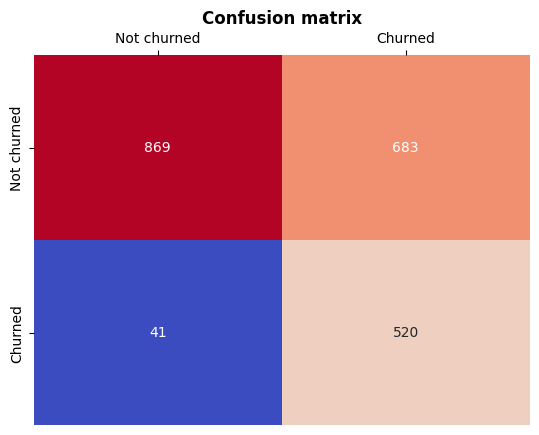

In [28]:
# make predictions 
## fbeta & classification report
val_predictions = model.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
print(f"FBeta score: {val_fbeta} \nClassification report: \n{classification_report(materials['y_test'], val_predictions)}")

## confusion matrix
data = confusion_matrix(materials['y_test'], val_predictions)
g = sns.heatmap(data, 
            annot=True, fmt='.0f', 
            cmap='coolwarm', cbar=False)
g.xaxis.tick_top()
g.set_xticklabels(['Not churned', 'Churned'])
g.set_yticklabels(['Not churned', 'Churned'])
g.set_title(label='Confusion matrix', 
            fontdict=dict(weight='bold'))

plt.show()